# Preface
Before I launch into the code I want to preface a misunderstanding I had about my data initially. I originally thought that the ` weighted_vote_score ` was a measure of the impact it had on the games review score. As it is instead a representation of the gauged helpfulness of the community, I now need to somewhat change my approach. 
Instead of focusing on attempting to guess within a range of the previous target parameter `weighted_vote_score` I'll instead need to approach it as attempting to guess 'Yes' or 'No' for whether or not they recommend the game (` voted_up `). 

# General Approach
As a whole I'll need to somewhat adjust the values in my data. I'll change the boolean values into 0 or 1 respectively, and drop the language column (since it appears to be entirely english). From here I'll only include the recieved_for_free, written_during_early_acces, weighted_vote_score, and review in the algorithm. This will then be fed into the algorithm to generate a guess on the voted_up scores. 

# Transforming the review column
Ultimately I need a way to perform sentiment analysis of the reviews to convert it from text into a numerical value of positivity or negativity. This in account with the other factors should (hopefully) get us a good guess of whether or not someone would recommend a game. 

In [1]:
import pandas as pd
from pathlib import Path

base_path = Path()
raw_data = base_path.joinpath('raw_data')
filtered_data = 'filtered_data.json'

filtered_df = pd.read_json(raw_data.joinpath(filtered_data))
filtered_df['review'] = filtered_df['review'].str.replace(r'\W+', ' ')
filtered_df[['voted_up', 'received_for_free', 'written_during_early_access']] = filtered_df[['voted_up', 'received_for_free', 'written_during_early_access']].astype(int)
filtered_df.drop(columns='language', inplace=True, axis=1)
display(filtered_df.head(10))

C:\Users\sebas\AppData\Local\Temp\ipykernel_7536\1799129055.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  filtered_df['review'] = filtered_df['review'].str.replace(r'\W+', ' ')


,ids,recommendationid,voted_up,received_for_free,written_during_early_access,weighted_vote_score,review
0,70,115513013,1,0,0,0.729283,Review of Half Life Revolutionizing the indus...
1,70,115813617,1,0,0,0.642857,A must play classic
2,70,115817244,1,0,0,0.615385,One of the best games every created still fun ...
3,70,115566933,1,0,0,0.613007,sp is pretty cool deathmatch goes crazy
4,70,116146745,1,0,0,0.583333,I m Kayne West and this is the Kayne best
5,70,116216878,1,0,0,0.565217,1998
6,70,115547553,0,0,0,0.537176,I ve come to make an announcement Gordon Freem...
7,70,115619966,1,0,0,0.527528,Yes
8,70,116243034,1,0,0,0.526959,OMFG BEST GRAPHICSSSSSSSSSSSSSS
9,70,115766562,1,0,0,0.525862,very noice game


In [2]:
#We filter this to cut down on the amount I have to pad. I can capture ~90% of the data by cutting it off at 1350 characters.
#With just slicing the first 100 reviews I was able to go from ~9min down to 30 seconds. 
#I've tried experimenting with some of the methods to speed up the process, but I haven't been able to get much to work without something else breaking.

print(filtered_df['review'].apply(len).quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
filtered_df = filtered_df.loc[filtered_df['review'].apply(len) < 1350]

0.25      80.00
0.50     238.00
0.75     613.00
0.90    1347.00
0.95    2088.35
0.99    4310.00
Name: review, dtype: float64


# Sentiment Analysis
This portion of the process has been somewhat of a struggle. While I could use NLTK or similar libaries to maybe get a good guess at the sentiment values, I want to test if a Neural Network model can get resonably close as well. First I had to figure out how to shape the data in a way that the Neural Network would properly work with, via subclassing the Dataset class, then I had to define various methods to make the data work.

Right now the Dataset takes too long to process, at least in order for me to submit the assignment in at a resonable time, however I will improve the effciency of this such that we can get a good test of the neural network benefits.

After a couple days of working out the issues in the Dataset subclass, I was able to have a working model of the data to plug into the CNN Sentiment Analysis model. From what I could find CNN models worked reasonably well at learning the sentiments of datasets as well as long-term patterns. So I opted to utilize this method and implement a model to guess the data.

This process took a while to get it right, but finally I was left with my current model. The inital tests with a limited selection showed to be promising whe compared to the test set - but against the total dataframe it just guessed everything as being a recommended review - which isn't ideal. At the moment I'm going to assume its from having too many unexpected tokens - resulting in poor performance, but it's hard to say until I can train it against the whole of the dataset. 

In [3]:
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchtext
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.tokenizer = torchtext.data.get_tokenizer('basic_english')
        self.max_seq_len = self._infer_max_seq_len()
        self.tokenized_data = self._tokenize_reviews()
        self.vocab = self._build_vocab()
        self.numericalized_data = self._numericalize_data()

    def _infer_max_seq_len(self):
        max_seq_len = 0
        for text in self.df['review']:
            tokens = self.tokenizer(text)
            max_seq_len = max(max_seq_len, len(tokens))
        return max_seq_len
    
    def _tokenize_reviews(self):
        tokenized_reviews = []
        with ThreadPoolExecutor() as executor:
            for tokens in tqdm(executor.map(self.tokenizer, self.df['review']), desc='Tokenizing Reviews', total=len(self.df['review'])):
                tokenized_reviews.append(tokens)
        return tokenized_reviews

    def _build_vocab(self):
        vocab = torchtext.vocab.build_vocab_from_iterator(self.tokenized_data, specials=['<unk>', '<pad>'])
        vocab.set_default_index(vocab['<unk>'])
        return vocab

    def _numericalize_data(self):
            tokenized_reviews = self.tokenized_data 
            vocab_stoi_data = self.get_vocab()
            numericalized_reviews = np.ones((len(tokenized_reviews), self.max_seq_len), dtype=np.int64)
            for i, tokens in tqdm(enumerate(tokenized_reviews), desc='Numericalizing Tokens', total=len(tokenized_reviews)):
                numericalized_tokens = [vocab_stoi_data[token] for token in tokens]
                numericalized_reviews[i, :len(numericalized_tokens)] = numericalized_tokens[:self.max_seq_len]
            return torch.from_numpy(numericalized_reviews), torch.tensor(self.df['voted_up'].values, dtype=torch.long)

    def __len__(self):
        return len(self.numericalized_data[0])

    def __getitem__(self, idx):
        numericalized_review = self.numericalized_data[0][idx]
        label = self.numericalized_data[1][idx]
        return torch.tensor(numericalized_review), torch.tensor(label)

    def get_vocab(self, index=False):
        '''Returns the vocab object as number index if true, else as string index'''
        return self.vocab.get_itos() if index else self.vocab.get_stoi()



In [4]:
train_dataframe, test_dataframe = train_test_split(filtered_df[['review', 'voted_up']], test_size=0.2, random_state=42)
train_data = CustomDataset(train_dataframe)
test_data = CustomDataset(test_dataframe)

Tokenizing Reviews:   0%|          | 0/82720 [00:00<?, ?it/s]

Numericalizing Tokens:   0%|          | 0/82720 [00:00<?, ?it/s]

Tokenizing Reviews:   0%|          | 0/20681 [00:00<?, ?it/s]

Numericalizing Tokens:   0%|          | 0/20681 [00:00<?, ?it/s]

In [5]:
print(f'Unknown Index: {train_data.get_vocab()["<unk>"]} \n Pad Index: {train_data.get_vocab()["<pad>"]}')
print(train_data[0][0])
print(test_data[0][0])

Unknown Index: 0 
 Pad Index: 1
tensor([   30,   143,   179,    29,   236,   450,   372,   326,   309,   432,
        14844, 32826,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,    

C:\Users\sebas\AppData\Local\Temp\ipykernel_7536\3722360226.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(numericalized_review), torch.tensor(label)


In [6]:
import torch.nn.functional as F

class SentimentCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        seed = 42
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=n_filters,
                      kernel_size=fsz)
            for fsz in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text = [batch size, sent len]
        embedded = self.embedding(text)
        # embedded = [batch size, sent len, emb dim]
        embedded = embedded.permute(0, 2, 1)  # [batch size, emb dim, sent len]

        # apply convolutions and activation functions
        conved = [F.relu(conv(embedded)) for conv in self.convs]

        # pooling
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        # concatenate pooled features and pass through the dropout layer
        cat = self.dropout(torch.cat(pooled, dim=1))

        # pass through the fully connected layer
        out = self.fc(cat)

        return out

In [7]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=128)

In [11]:
tuning_train_data = CustomDataset(train_dataframe[:1024])
tuning_test_data = CustomDataset(test_dataframe[:1024])
tuning_train_data_loader = torch.utils.data.DataLoader(tuning_train_data, batch_size=32, shuffle=True)
tuning_test_data_loader = torch.utils.data.DataLoader(tuning_test_data, batch_size=32)

Tokenizing Reviews:   0%|          | 0/1024 [00:00<?, ?it/s]

Numericalizing Tokens:   0%|          | 0/1024 [00:00<?, ?it/s]

Tokenizing Reviews:   0%|          | 0/1024 [00:00<?, ?it/s]

Numericalizing Tokens:   0%|          | 0/1024 [00:00<?, ?it/s]

0it [00:00, ?it/s]

C:\Users\sebas\AppData\Local\Temp\ipykernel_7536\3722360226.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(numericalized_review), torch.tensor(label)


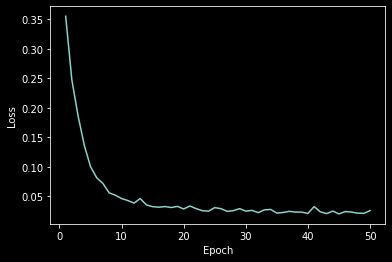

Accuracy on test set: 67.65%


In [8]:
import matplotlib.pyplot as plt

avail_device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(avail_device)

vocab_size = len(train_data.vocab)
emb_dim = 200
num_filters = 200
filter_sizes = [2, 3, 4, 5]
output_dim = 2
dropout = 0.2

model = SentimentCNN(vocab_size, emb_dim, num_filters, filter_sizes, output_dim, dropout)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# train the model
epochs = 50
model.train()
train_segment_pbar = tqdm()
train_loader_len = train_data_loader.__len__()
loss_data = []
for epoch in range(epochs):
    running_loss = 0.0
    train_segment_pbar.set_description(f'Training Epoch {epoch+1}/{epochs}')
    train_segment_pbar.reset(total=train_loader_len)
    for batch in train_data_loader:
        train_segment_pbar.update()
        optimizer.zero_grad()
        text, label = batch
        text = text.to(device)
        label = label.to(device)
        output = model(text)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_segment_pbar.refresh()
    loss_data.append((epoch+1, running_loss/len(train_data_loader)))

# plot the loss
plt.plot(*zip(*loss_data))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# evaluate the model on test set
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        text, label = batch
        text = text.to(device)
        label = label.to(device)
        output = model(text)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
print(f'Accuracy on test set: {100 * correct / total:.2f}%')

In [29]:
torch.save(model.state_dict(), raw_data.joinpath('model.pt'))
torch.save(train_data.get_vocab(), raw_data.joinpath('vocab.pt'))

# Sentiment predictions
My overall approach here is to get the sentiment values of each word by training the model to correctly guess the `voted_up` field and develop the necessary coeffecients to do so. 

The process to extract their coeffients involves the following steps:
   1. The input text is first tokenized using the basic_english tokenizer from torchtext.
   1.  The tokenized text is then converted to numerical form by mapping each token to its corresponding index in the vocabulary.
   1.  The numericalized tokens are then padded to a fixed length to ensure that all inputs have the same shape.
   1.  The padded numericalized tokens are passed through the embedding layer of the model to obtain their corresponding word embeddings.
   1.  The mean embedding for each review is calculated by taking the element-wise product of the embedding tensor and a binary mask tensor (which is 1 for tokens that are present and 0 for tokens that are padded) and then taking the mean along the sequence dimension.
   1.  The mean embeddings are passed through a 1D convolutional layer (model.convs[0]), followed by a non-linear activation function (torch.tanh).
   1.  The output of the convolutional layer is a 3D tensor with shape (batch_size, num_filters, seq_len - filter_size + 1).
   1.  The tensor is then squeezed along the third dimension (i.e., `output = output.squeeze(3)`), resulting in a 2D tensor with shape ( `batch_size, num_filters, seq_len - filter_size + 1`).
   1.  The tensor is then averaged along the third dimension (i.e., `output = output.mean(dim=2)`), resulting in a 2D tensor with shape (`batch_size, num_filters`).
   1.  The tensor is then squeezed along the first dimension (i.e., `output = output.squeeze()`), resulting in a 1D tensor with shape (`num_filters,`).
   1.  The final sentiment score for each review is obtained by taking the hyperbolic tangent of the average of the values in the 1D tensor (i.e., `torch.tanh(output.mean())`). This forces the value between -1 and 1, resulting in the actual sentiment score of the word in context to the sentence.

Then I take the resulting lists, and iteratively strip the NaN values from them, this will allow me to more effeciently process the list later once it is inside of the dataframe.
Finally in the dataframe I take the average of the values of the words in the sentences to get the final sentiment score of the sentence, dropping the last set of NaN values for sentences that we can't produce a score for (due to lack of vocab across the sentence).

In [13]:
import concurrent.futures

def predict_sentiment(df, vocab):
    # Tokenize the review text
    tokenizer = torchtext.data.get_tokenizer('basic_english')
    temp_df = df['review'].apply(tokenizer)
    max_seq_len = max(map(len, temp_df))

    # Convert the tokens to numericalized form
    numericalized_tokens = torch.zeros((len(temp_df), max(map(len, temp_df))), dtype=torch.long)
    with ThreadPoolExecutor() as executor:
        for i, tokens in enumerate(executor.map(lambda x: x[:max_seq_len], temp_df)):
            numericalized_tokens[i, :len(tokens)] = torch.tensor([vocab[token] if token in vocab else vocab['<unk>'] for token in tokens])

    padded_tokens = numericalized_tokens.unsqueeze(1)

    # Calculate the sentiment score based on the mean value of the word embeddings
    with torch.no_grad():
        model.eval()
        model.convs.eval()
        embeddings = model.embedding(padded_tokens)
        mask = padded_tokens.ne(0).unsqueeze(-1).float()
        mean_embeddings = embeddings.mul(mask).sum(dim=1).div(mask.sum(dim=1))
        mean_embeddings = mean_embeddings.permute(0, 2, 1)
        output = model.convs[0](mean_embeddings)
        output = output.squeeze(2)
        output = output.mean(dim=1)
        output = output.view(output.shape[0], -1)
        sentiment_scores = torch.sigmoid(output).squeeze().tolist()

    # Return the sentiment scores as a new column in the dataframe
    sentiments = []
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(lambda x: np.array(x, dtype=np.float32)[~np.isnan(x)].tolist(), review_sentiment) for review_sentiment in sentiment_scores]
        concurrent.futures.wait(futures)
        for future in futures:
            sentiments.append(future.result())

    return sentiments


In [14]:
import concurrent.futures

def batch_predict_sentiment(df, batch_size):
    # Reset the index of the DataFrame
    df = df.reset_index(drop=True)
    vocab = train_data.get_vocab()
    # Split the DataFrame into batches
    num_batches = int(np.ceil(len(df) / batch_size))
    batches = np.array_split(df, num_batches)

    # Create a ThreadPoolExecutor with a maximum of 4 worker threads
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        # Submit each batch to the executor and store the Future objects
        futures = [executor.submit(predict_sentiment, batch, vocab) for batch in tqdm(batches, desc='Submitting Batches', total=num_batches)]
        
        # Wait for all the Future objects to complete and get their results
        results = [future.result() for future in tqdm(concurrent.futures.as_completed(futures), desc='Getting Results', total=num_batches)]
    
    # Flatten the list of results
    results = [sentiment for batch_sentiments in results for sentiment in batch_sentiments]
        
    # Return the results as a new column in the original DataFrame
    df['sentiments'] = results
    return df

In [15]:
import cProfile
temp_df = filtered_df
batch_size = 5000
temp_df = batch_predict_sentiment(temp_df, batch_size)

Submitting Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Getting Results:   0%|          | 0/21 [00:00<?, ?it/s]

In [17]:
print(temp_df.head(1)['sentiments'].values)
temp_df['sentiments'] = temp_df['sentiments'].apply(lambda x: np.mean(x))
temp_df.dropna(inplace=True)
temp_df.sort_values(by='sentiments', ascending=False, inplace=True)
display(temp_df)

[0.95314127]


,ids,recommendationid,voted_up,received_for_free,written_during_early_access,weighted_vote_score,review,sentiments
99266,6910,115752306,1,0,0,0.614178,Lip smack,0.953141
5235,1119980,115978184,1,0,0,0.523810,Great game A prime example that a game does no...,0.953141
8730,614090,85475210,1,0,0,0.512579,Can you make beat em up work with one punch co...,0.950278
20742,949170,49702623,0,0,0,0.473567,Caveat Emptor,0.949970
36093,344300,48834720,1,0,0,0.485808,LAPS LAPS LAPS,0.936660
...,...,...,...,...,...,...,...,...
89930,1108750,109048125,1,0,0,0.673469,A very cool shooter for the first time I see a...,0.000373
72078,680330,42078533,0,0,0,0.597946,DO NOT BUY THIS YET very glitchy lighting and ...,0.000373
48058,285900,115948007,1,0,0,0.523810,this is a game,0.000373
6443,530950,42060452,1,0,0,0.655085,Well it s been 3 hours and I m done but I have...,0.000259


# In review
So in review I have made good strides in accomplishing part of my goal, and generating features for the dataset. However my downfall is a tandem of the effeciency of the code, and not performing more cleaning steps on the text (i.e not converting contractions to their long-form before stripping punctuation like apostrophes). Once some more of these steps are done and I am able to process the full dataset for training - I think the overall performance of the model will improve drastically. I definitely still have a lot more to learn about PyTorch and its associated libraries, but I am somewhat happy with how far I have come.